https://www.pymc-marketing.io/en/stable/notebooks/

https://medium.com/towards-data-science/calibrating-marketing-mix-models-in-python-49dce1a5b33d

https://github.com/pymc-labs/pymc-marketing/issues/1457

https://github.com/pymc-labs/pymc-marketing/discussions/1486

# Imports

In [1]:
import pytensor  
pytensor.config.floatX = 'float32' # Workaround for a bug in pymc_marketing

import gc

import numpy as np
import pandas as pd

from sklearn.preprocessing import MaxAbsScaler

from cromp import CROMPTrain, CROMPPredict
import cvxpy as cp

import pymc
from pymc_marketing.mmm import MMM, GeometricAdstock, LogisticSaturation, MichaelisMentenSaturation
from pymc_marketing.prior import Prior

import arviz as az
import matplotlib.pyplot as plt
import seaborn as sns

WARNING (pytensor.tensor.blas): Using NumPy C-API based implementation for BLAS functions.
C:\Users\kbope\anaconda3\envs\mmm\Lib\site-packages\pandas\core\arrays\masked.py:60: UserWarning: Pandas requires version '1.3.6' or newer of 'bottleneck' (version '1.3.5' currently installed).
  from pandas.core import (


# UDFs

In [2]:
def _mape(predictions, actuals):
    return abs((predictions - actuals) / actuals).mean()

def get_scaled_data(do_scaling, scaler_X, scaler_y, X, y=None, must_scale_feats=[]):
    if do_scaling:
        X_scaled = pd.DataFrame(data=scaler_X.transform(X), index=X.index, columns=list(X.columns))
        if y is not None:
            y_scaled = pd.Series(data=scaler_y.transform(y.values.reshape(-1, 1)).flatten(), index=y.index)
        else:
            y_scaled = y
    elif len(must_scale_feats):
        X_scaled = pd.DataFrame(data=scaler_X.transform(X), index=X.index, columns=list(X.columns))
        for feat in X.columns:
            if feat not in must_scale_feats:
                X_scaled[feat] = X[feat]
        y_scaled = y
    else:
        X_scaled = X
        y_scaled = y
    
    return X_scaled, y_scaled

# Data

## Load

In [3]:
df1 = pd.read_csv('data/data1.csv')
df1.rename(columns={'sales': 'y'}, inplace=True)
df1['date'] = pd.to_datetime(df1.date, format='%Y-%m-%d')
df1.set_index('date', inplace=True)
df1.head()

,y,demand_proxy,tv_spend_raw,social_spend_raw,search_spend_raw
date,,,,,
2021-01-03,489.566208,330.831226,5501.441206,5894.908137,7182.864568
2021-01-10,441.138691,317.461345,2507.942445,5791.555554,6312.367780
2021-01-17,152.309451,89.223970,1049.661462,1081.642708,1429.740857
2021-01-24,367.160745,169.729439,3008.937195,5323.913163,6185.584938
2021-01-31,465.083840,349.047382,3171.490614,6830.642777,7227.783598


In [4]:
df2 = pd.read_csv('data/data2.csv')
df2['date'] = pd.to_datetime(df2.date_week, format='%d-%m-%Y')
df2.drop('date_week', axis=1, inplace=True)
df2.set_index('date', inplace=True)
df2.head()

,y,x1,x2,event_1,event_2,dayofyear
date,,,,,,
2018-04-02,3984.662237,0.318580,0.0,0,0,92
2018-04-09,3762.871794,0.112388,0.0,0,0,99
2018-04-16,4466.967388,0.292400,0.0,0,0,106
2018-04-23,3864.219373,0.071399,0.0,0,0,113
2018-04-30,4441.625278,0.386745,0.0,0,0,120


In [5]:
df3 = pd.read_csv('data/data3.csv')
df3.rename(columns={'sales': 'y'}, inplace=True)
df3['date'] = pd.to_datetime(df3.wk_strt_dt, format='%Y-%m-%d')
df3.drop('wk_strt_dt', axis=1, inplace=True)
df3.set_index('date', inplace=True)
df3.head()

,y,Direct Mail,Insert,Newspaper,Online Display,Radio,Social Media,TV,hldy_Black Friday,hldy_Christmas Day,...,hldy_Memorial Day,hldy_Mother's Day,hldy_NYE,hldy_New Year's Day,hldy_Pre Thanksgiving,hldy_Presidents Day,hldy_Prime Day,hldy_Thanksgiving,hldy_Valentine's Day,hldy_Veterans Day
date,,,,,,,,,,,,,,,,,,,,,
2014-08-03,72051457.64,678410.26,129759.66,507635.16,61364.75,254134.14,0.0,216725.59,0,0,...,0,0,0,0,0,0,0,0,0,0
2014-08-10,78794770.54,661097.71,70355.33,625719.37,132643.90,106602.98,0.0,108919.26,0,0,...,0,0,0,0,0,0,0,0,0,0
2014-08-17,70071185.56,1874338.43,107720.37,277532.61,76741.27,59011.42,0.0,74032.19,0,0,...,0,0,0,0,0,0,0,0,0,0
2014-08-24,68642464.59,306583.37,141708.61,186028.61,193043.55,178010.46,0.0,110995.66,0,0,...,0,0,0,0,0,0,0,0,0,0
2014-08-31,86190784.65,2366274.16,160691.30,706694.09,249612.89,144097.56,0.0,225140.84,0,0,...,0,0,0,0,0,0,0,0,0,0


In [6]:
df4 = pd.read_csv('data/data4.csv')
df4['date'] = pd.to_datetime(df4.date_week, format='%Y-%m-%d')
df4.drop('date_week', axis=1, inplace=True)
df4.set_index('date', inplace=True)
df4.head()

,holiday_signal,competitor_offers,x1,x2,market_growth,y
date,,,,,,
2022-01-01,5.244234e-45,2.000000,4.850376,12.239569,0.778279,8.236027
2022-01-02,9.276916e-45,2.000009,4.897980,12.349051,0.780413,9.470106
2022-01-03,1.638439e-44,2.000036,4.848861,12.236060,0.782539,9.800233
2022-01-04,2.889097e-44,2.000082,4.685502,11.860301,0.784657,9.743402
2022-01-05,5.086267e-44,2.000146,4.906353,12.368215,0.786768,10.112234


In [7]:
causal_dag = """digraph {x1 -> y;
                         x2 -> y;
                         x1 -> x2;
                         holiday_signal -> y;
                         holiday_signal -> x1;
                         holiday_signal -> x2;
                         competitor_offers -> x2;
                         competitor_offers -> y;
                         market_growth -> y;}"""

In [8]:
df5 = pd.read_csv('data/data5.csv')
df5['date'] = pd.to_datetime(df5.date_week, format='%Y-%m-%d')
df5.drop('date_week', axis=1, inplace=True)
df5.set_index('date', inplace=True)
df5.head()

,x1,x2,event_1,event_2,y
date,,,,,
2018-04-02,0.294756,0.0,0.0,0.0,7.787554
2018-04-09,0.938322,0.0,0.0,0.0,8.788564
2018-04-16,0.139732,0.0,0.0,0.0,8.815248
2018-04-23,0.261709,0.0,0.0,0.0,8.583922
2018-04-30,0.374697,0.0,0.0,0.0,8.775528


## Generate

# Pre-process

In [9]:
df = df4.copy()
do_causal = False

#channel_columns = ['tv_spend_raw', 'social_spend_raw', 'search_spend_raw']
#control_columns = ['demand_proxy']

#channel_columns = ['x1', 'x2']
#control_columns = ['event_1', 'event_2']

#channel_columns = ['Direct Mail', 'Insert', 'Newspaper', 'Online Display', 'Radio', 'Social Media', 'TV']
#control_columns = [col for col in df.columns if "hldy_" in col]

channel_columns = ['x1', 'x2']
control_columns = ['holiday_signal']
do_causal = True

#channel_columns = ['x1', 'x2']
#control_columns = ['event_1', 'event_2']

In [10]:
df['t'] = range(df.shape[0])
control_columns += ['t']
df.head()

,holiday_signal,competitor_offers,x1,x2,market_growth,y,t
date,,,,,,,
2022-01-01,5.244234e-45,2.000000,4.850376,12.239569,0.778279,8.236027,0
2022-01-02,9.276916e-45,2.000009,4.897980,12.349051,0.780413,9.470106,1
2022-01-03,1.638439e-44,2.000036,4.848861,12.236060,0.782539,9.800233,2
2022-01-04,2.889097e-44,2.000082,4.685502,11.860301,0.784657,9.743402,3
2022-01-05,5.086267e-44,2.000146,4.906353,12.368215,0.786768,10.112234,4


## EDA

In [11]:
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 1041 entries, 2022-01-01 to 2024-11-06
Data columns (total 7 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   holiday_signal     1041 non-null   float64
 1   competitor_offers  1041 non-null   float64
 2   x1                 1041 non-null   float64
 3   x2                 1041 non-null   float64
 4   market_growth      1041 non-null   float64
 5   y                  1041 non-null   float64
 6   t                  1041 non-null   int64  
dtypes: float64(6), int64(1)
memory usage: 65.1 KB


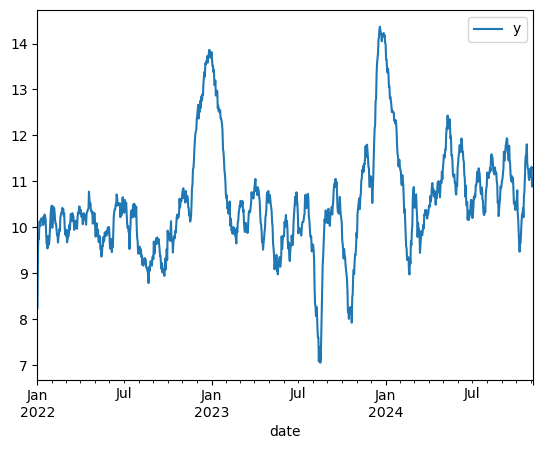

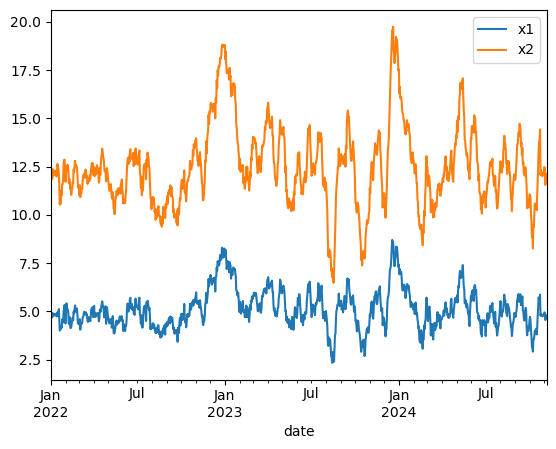

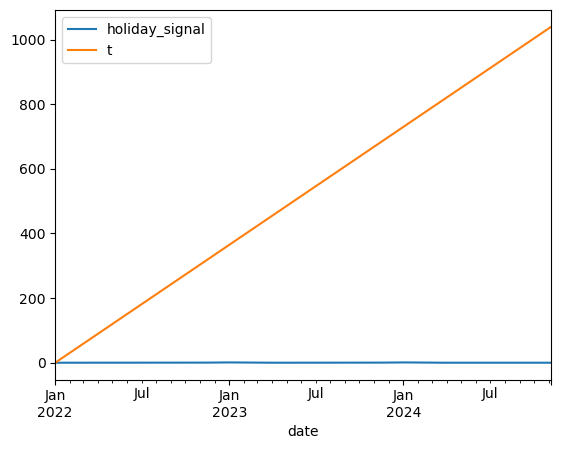

In [12]:
df[['y']].plot();
df[channel_columns].plot();
df[control_columns].plot();

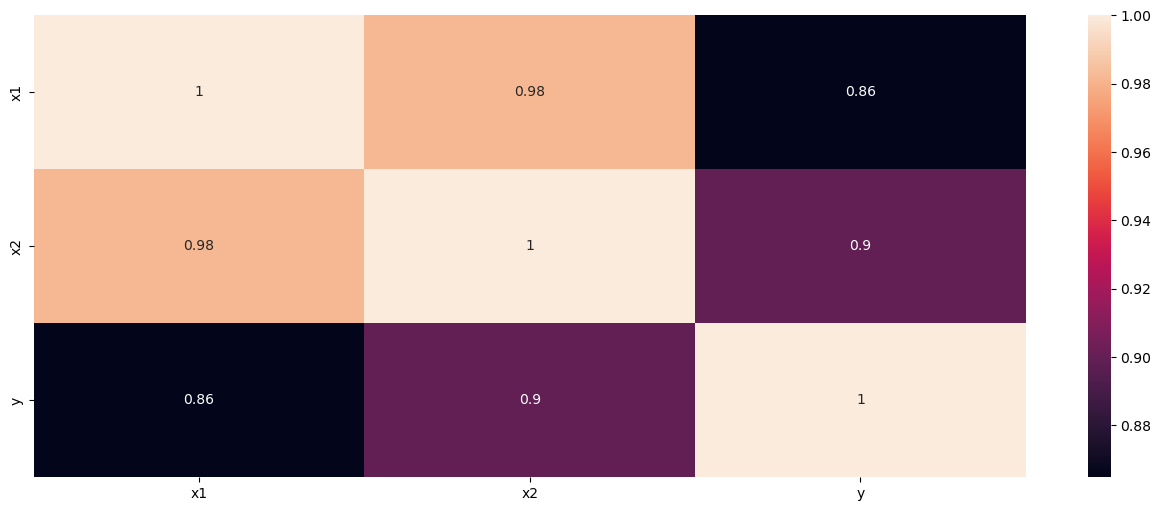

In [13]:
fig, ax = plt.subplots(figsize=(16, 6))
sns.heatmap(df[channel_columns+['y']].corr(), annot=True, ax=ax);

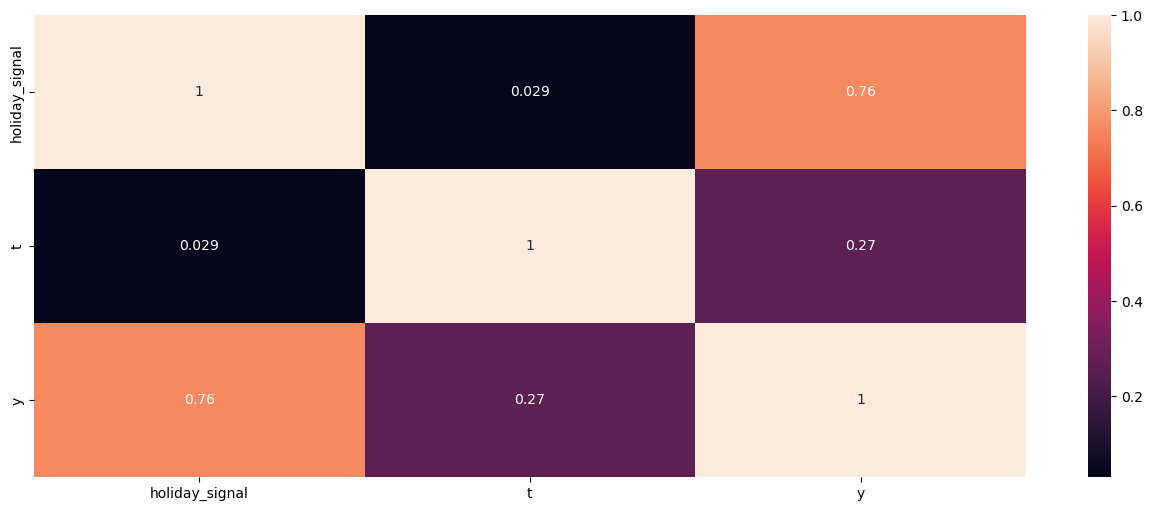

In [14]:
fig, ax = plt.subplots(figsize=(16, 6))
sns.heatmap(df[control_columns+['y']].corr(), annot=True, ax=ax);

## Test Split

In [15]:
split_n = int(df.shape[0] * 0.3)
split_n -= split_n % 3
split_n

In [16]:
df_train = df.iloc[:-split_n]
df_test = df.iloc[-split_n:]

In [17]:
X_train = df_train.drop('y', axis=1)
y_train = df_train['y']

X_test = df_test.drop('y', axis=1)
y_test = df_test['y']

# Model

## Scale

In [18]:
scaler_X = MaxAbsScaler().fit(X_train)
scaler_y = MaxAbsScaler().fit(y_train.values.reshape(-1, 1))

## Constrained Regression

### CROMP

#### Defaults

In [19]:
intercept = True
do_scaling = True

#### Constraints

In [20]:
lb = []
ub = []
if do_scaling:
    if intercept:
        lb = [0]
        ub = [1]
        
    for col in X_train.columns:
        if col in control_columns:
            lb += [-1]
            ub += [1]
        else:
            lb += [0]
            ub += [1]
else:
    if intercept:
        lb = [0]
        ub = [np.Inf]
        
    for col in X_train.columns:
        if col in channel_columns:
            lb += [0]
            ub += [np.Inf]
        else:
            lb += [-np.Inf]
            ub += [np.Inf]

#### Fit

In [21]:
X_train_scaled, y_train_scaled = get_scaled_data(do_scaling, scaler_X, scaler_y, X_train, y_train)
df_train_scaled = X_train_scaled.copy()
df_train_scaled['y'] = y_train_scaled

In [22]:
model_regression = CROMPTrain()
ret = model_regression.config_constraints(feats_in_asc_order=[],
                                          feats_in_no_order=list(X_train_scaled.columns), 
                                          lb=lb, 
                                          ub=ub, 
                                          no_intercept=not(intercept))
print(ret)

True


In [23]:
if ret == True:
    ret, model_regression = model_regression.train(df_train_scaled, 'y')
    print(ret)

if ret == True:
    if intercept:
        print("\nPredicted scaled intercept from CROMP:", model_regression['coeffs'][0])
    print("Predicted scaled coefficients from CROMP:", model_regression['coeffs'][1:])

True

Predicted scaled intercept from CROMP: 0.3987486621291793
Predicted scaled coefficients from CROMP: [ 1.27590407e-01  2.91086076e-11  4.23298065e-12  4.95360819e-01
  5.84171371e-10 -1.76165564e-02]


#### Validate

In [24]:
X_test_scaled, _ = get_scaled_data(do_scaling, scaler_X, scaler_y, X_test)
X_test_scaled.head()

,holiday_signal,competitor_offers,x1,x2,market_growth,t
date,,,,,,
2023-12-31,0.961558,0.884550,0.838896,0.884807,1.000435,1.001374
2024-01-01,0.950089,0.883592,0.851774,0.887926,1.000869,1.002747
2024-01-02,0.937255,0.882631,0.795126,0.824826,1.001304,1.004121
2024-01-03,0.923116,0.881670,0.824977,0.842218,1.001738,1.005495
2024-01-04,0.907738,0.880706,0.799694,0.812000,1.002171,1.006868


In [25]:
model_regression = CROMPPredict(model_regression)

In [26]:
if ret == True:
    result_scaled = model_regression.predict(X_test_scaled)
    if do_scaling:
        result = pd.Series(data=scaler_y.inverse_transform(result_scaled.values.reshape(-1, 1)).flatten(), 
                           index=X_test.index)
    else:
        result = result_scaled
    print("MAPE from CROMP:", _mape(result, y_test))
    print(result.head())

MAPE from CROMP: 0.08816960159424275
date
2023-12-31    13.533402
2024-01-01    13.534224
2024-01-02    13.061339
2024-01-03    13.158837
2024-01-04    12.915269
dtype: float64


#### Cleanup

In [27]:
del df_train_scaled
gc.collect();

### CVXPY

#### Defaults

In [28]:
intercept = True
do_scaling = True

In [29]:
X_train_scaled, y_train_scaled = get_scaled_data(do_scaling, scaler_X, scaler_y, X_train, y_train)

In [30]:
if intercept:
    X_train_scaled['intercept'] = 1

In [31]:
n_coef = X_train_scaled.shape[1]
coef = cp.Variable(n_coef)

#### Constraints

In [32]:
reg_alpha = 1.0
ridge_penalty = cp.norm(coef, 2)

In [33]:
lb = []
ub = []
if do_scaling:
    for col in X_train.columns:
        if col in control_columns:
            lb += [-1]
            ub += [1]
        else:
            lb += [0]
            ub += [1]
            
    if intercept:
        lb += [0]
        ub += [1]
else:   
    for col in X_train.columns:
        if col in channel_columns:
            lb += [0]
            ub += [None]
        else:
            lb += [None]
            ub += [None]
    
    if intercept:
        lb += [0]
        ub += [None]

In [34]:
constraints = ([coef[i] >= lb[i] for i in range(n_coef) if lb[i] is not None] +
               [coef[i] <= ub[i] for i in range(n_coef) if ub[i] is not None])
constraints

[Inequality(Constant(CONSTANT, NONPOSITIVE, ())),
 Inequality(Constant(CONSTANT, ZERO, ())),
 Inequality(Constant(CONSTANT, ZERO, ())),
 Inequality(Constant(CONSTANT, ZERO, ())),
 Inequality(Constant(CONSTANT, ZERO, ())),
 Inequality(Constant(CONSTANT, NONPOSITIVE, ())),
 Inequality(Constant(CONSTANT, ZERO, ())),
 Inequality(Expression(AFFINE, UNKNOWN, ())),
 Inequality(Expression(AFFINE, UNKNOWN, ())),
 Inequality(Expression(AFFINE, UNKNOWN, ())),
 Inequality(Expression(AFFINE, UNKNOWN, ())),
 Inequality(Expression(AFFINE, UNKNOWN, ())),
 Inequality(Expression(AFFINE, UNKNOWN, ())),
 Inequality(Expression(AFFINE, UNKNOWN, ()))]

#### Fit

In [35]:
objective = cp.Minimize(cp.sum_squares(X_train_scaled.values @ coef - y_train_scaled.values) + reg_alpha * ridge_penalty)
problem = cp.Problem(objective, constraints)
problem.solve()
print(problem.status)

optimal


In [36]:
if problem.status == 'optimal':
    if intercept:
        print("\nPredicted scaled intercept from CVXPY:", coef.value[0])
        print("Predicted scaled coefficients from CVXPY:", coef.value[1:])
    else:
        print("Predicted scaled coefficients from CVXPY:", coef.value)


Predicted scaled intercept from CVXPY: 0.12837860877091833
Predicted scaled coefficients from CVXPY: [ 1.85202559e-10  1.92067069e-01  2.83976403e-01  7.84848602e-02
 -5.91032475e-02  3.76760882e-01]


#### Validate

In [37]:
X_test_scaled, _ = get_scaled_data(do_scaling, scaler_X, scaler_y, X_test)
if intercept:
    X_test_scaled['intercept'] = 1
X_test_scaled.head()

,holiday_signal,competitor_offers,x1,x2,market_growth,t,intercept
date,,,,,,,
2023-12-31,0.961558,0.884550,0.838896,0.884807,1.000435,1.001374,1
2024-01-01,0.950089,0.883592,0.851774,0.887926,1.000869,1.002747,1
2024-01-02,0.937255,0.882631,0.795126,0.824826,1.001304,1.004121,1
2024-01-03,0.923116,0.881670,0.824977,0.842218,1.001738,1.005495,1
2024-01-04,0.907738,0.880706,0.799694,0.812000,1.002171,1.006868,1


In [38]:
if problem.status == 'optimal':
    result_scaled = X_test_scaled.values @ coef.value
    if do_scaling:
        result = pd.Series(data=scaler_y.inverse_transform(result_scaled.reshape(-1, 1)).flatten(), index=X_test.index)
    else:
        result = pd.Series(data=result_scaled, index=X_test.index)
    print("MAPE from CVXPY:", _mape(result, y_test))
    print(result.head())

MAPE from CVXPY: 0.10298390304583539
date
2023-12-31    13.387385
2024-01-01    13.413808
2024-01-02    12.975760
2024-01-03    13.102316
2024-01-04    12.880249
dtype: float64


#### Cleanup

In [39]:
if intercept:
    X_train_scaled.drop('intercept', axis=1, inplace=True)
    X_test_scaled.drop('intercept', axis=1, inplace=True)

## Bayesian

In [40]:
#?MMM

### Defaults

In [41]:
channel_columns = channel_columns
control_columns = control_columns

adstock = GeometricAdstock(l_max=12)
saturation = LogisticSaturation()

fourier_modes = 4
time_varying_intercept = False
time_varying_media = True

do_scaling = False
do_causal = do_causal

sampler_config = {'chains': 4, 'draws': 2_000, 'tune': 1_500, 'progressbar': True,
                  'cores': 4, 
                  'nuts_sampler': 'numpyro',
                  'target_accept': 0.9, 
                  'random_seed':1}

In [42]:
if do_causal:
    causal_dag = causal_dag
    causal_config = {'outcome_node': 'y', 'dag': causal_dag}
    
    saturation = MichaelisMentenSaturation()
    time_varying_intercept = True
else:
    causal_config = {}

In [43]:
X_train_scaled, y_train_scaled = get_scaled_data(do_scaling, scaler_X, scaler_y, X_train, y_train, control_columns)
X_train_scaled['date_str'] = list(X_train_scaled.index.strftime("%Y-%m-%d"))
date_column = 'date_str'

In [44]:
model_bayesian = MMM(date_column=date_column, 
                     channel_columns=channel_columns, 
                     control_columns=control_columns,
                     adstock=adstock, 
                     adstock_first=True,
                     saturation=saturation, 
                     yearly_seasonality=fourier_modes,
                     time_varying_intercept=time_varying_intercept, 
                     time_varying_media=time_varying_media, 
                     **causal_config)
model_bayesian.model_config

C:\Users\kbope\anaconda3\envs\mmm\Lib\site-packages\pydantic\_internal\_validate_call.py:111: UserWarning: No treatment nodes provided, using channel columns as treatment nodes.
  res = self.__pydantic_validator__.validate_python(pydantic_core.ArgsKwargs(args, kwargs))
C:\Users\kbope\anaconda3\envs\mmm\Lib\site-packages\dowhy\causal_model.py:583: UserWarning: 6 variables are assumed unobserved because they are not in the dataset. Configure the logging level to `logging.WARNING` or higher for additional details.
  warnings.warn(
C:\Users\kbope\anaconda3\envs\mmm\Lib\site-packages\pymc_marketing\mmm\mmm.py:221: UserWarning: Columns {'t'} are not in the adjustment set. Controls are being modified.
  self.control_columns = self.causal_graphical_model.compute_adjustment_sets(
C:\Users\kbope\anaconda3\envs\mmm\Lib\site-packages\pymc_marketing\mmm\mmm.py:221: UserWarning: Column competitor_offers in adjustment set not found in data.
                    Not controlling for this may induce bias

{'intercept': Prior("Normal", mu=0, sigma=2),
 'likelihood': Prior("Normal", sigma=Prior("HalfNormal", sigma=2)),
 'gamma_control': Prior("Normal", mu=0, sigma=2, dims="control"),
 'gamma_fourier': Prior("Laplace", mu=0, b=1, dims="fourier_mode"),
 'intercept_tvp_config': HSGPKwargs(m=200, L=None, eta_lam=1.0, ls_mu=5.0, ls_sigma=10.0, cov_func=None),
 'media_tvp_config': HSGPKwargs(m=200, L=None, eta_lam=1.0, ls_mu=5.0, ls_sigma=10.0, cov_func=None),
 'adstock_alpha': Prior("Beta", alpha=1, beta=3, dims="channel"),
 'saturation_alpha': Prior("Gamma", mu=2, sigma=1, dims="channel"),
 'saturation_lam': Prior("HalfNormal", sigma=1, dims="channel")}

In [45]:
if do_causal:
    print(model_bayesian.causal_graphical_model.adjustment_set)
    print(model_bayesian.causal_graphical_model.minimal_adjustment_set)

['competitor_offers', 'holiday_signal']
['holiday_signal', 'x1', 'x2']


### Priors

In [46]:
#model_bayesian.model_config['intercept'] = Prior('Normal', mu=0.5, sigma=1)
model_bayesian.model_config['intercept'] = Prior('HalfNormal', sigma=0.5)

In [47]:
model_bayesian.model_config['gamma_fourier'] = Prior('Laplace', mu=0, b=1, dims='fourier_mode')
model_bayesian.model_config['gamma_control'] = Prior('Normal', mu=0, sigma=1, dims='control')

In [48]:
if do_causal:
    model_bayesian.model_config['intercept_tvp_config'].ls_mu = 100
else:
    total_spend_per_channel = X_train_scaled[channel_columns].sum(axis=0)
    channel_spend_share = total_spend_per_channel / total_spend_per_channel.sum()
    prior_channel_sigma = list(channel_spend_share.to_numpy())
    print(prior_channel_sigma)
    model_bayesian.model_config['saturation_beta'] = Prior('TruncatedNormal', mu=[0.01, 0.1, 0.5], lower=0, upper=0.8, 
                                                           sigma=prior_channel_sigma, dims='channel')

In [49]:
model_bayesian.model_config

{'intercept': Prior("HalfNormal", sigma=0.5),
 'likelihood': Prior("Normal", sigma=Prior("HalfNormal", sigma=2)),
 'gamma_control': Prior("Normal", mu=0, sigma=1, dims="control"),
 'gamma_fourier': Prior("Laplace", mu=0, b=1, dims="fourier_mode"),
 'intercept_tvp_config': HSGPKwargs(m=200, L=None, eta_lam=1.0, ls_mu=100, ls_sigma=10.0, cov_func=None),
 'media_tvp_config': HSGPKwargs(m=200, L=None, eta_lam=1.0, ls_mu=5.0, ls_sigma=10.0, cov_func=None),
 'adstock_alpha': Prior("Beta", alpha=1, beta=3, dims="channel"),
 'saturation_alpha': Prior("Gamma", mu=2, sigma=1, dims="channel"),
 'saturation_lam': Prior("HalfNormal", sigma=1, dims="channel")}

In [50]:
# Sample from prior predictive distribution
model_bayesian.sample_prior_predictive(X_train_scaled, y_train_scaled, samples=sampler_config['tune'])

Sampling: [adstock_alpha, baseline_intercept, gamma_control, intercept_temporal_latent_multiplier_raw_eta, intercept_temporal_latent_multiplier_raw_hsgp_coefs_offset, intercept_temporal_latent_multiplier_raw_ls, media_temporal_latent_multiplier_raw_eta, media_temporal_latent_multiplier_raw_hsgp_coefs_offset, media_temporal_latent_multiplier_raw_ls, saturation_alpha, saturation_lam, y, y_sigma]


<xarray.Dataset> Size: 4MB
Dimensions:  (date: 729, sample: 1500)
Coordinates:
  * date     (date) datetime64[ns] 6kB 2022-01-01 2022-01-02 ... 2023-12-30
  * sample   (sample) object 12kB MultiIndex
  * chain    (sample) int32 6kB 0 0 0 0 0 0 0 0 0 0 0 ... 0 0 0 0 0 0 0 0 0 0 0
  * draw     (sample) int32 6kB 0 1 2 3 4 5 6 ... 1494 1495 1496 1497 1498 1499
Data variables:
    y        (date, sample) float32 4MB 2.178 4.622 2.493 ... 2.774 3.019 1.874
Attributes:
    created_at:                 2025-02-12T13:03:12.328024+00:00
    arviz_version:              0.20.0
    inference_library:          pymc
    inference_library_version:  5.20.0

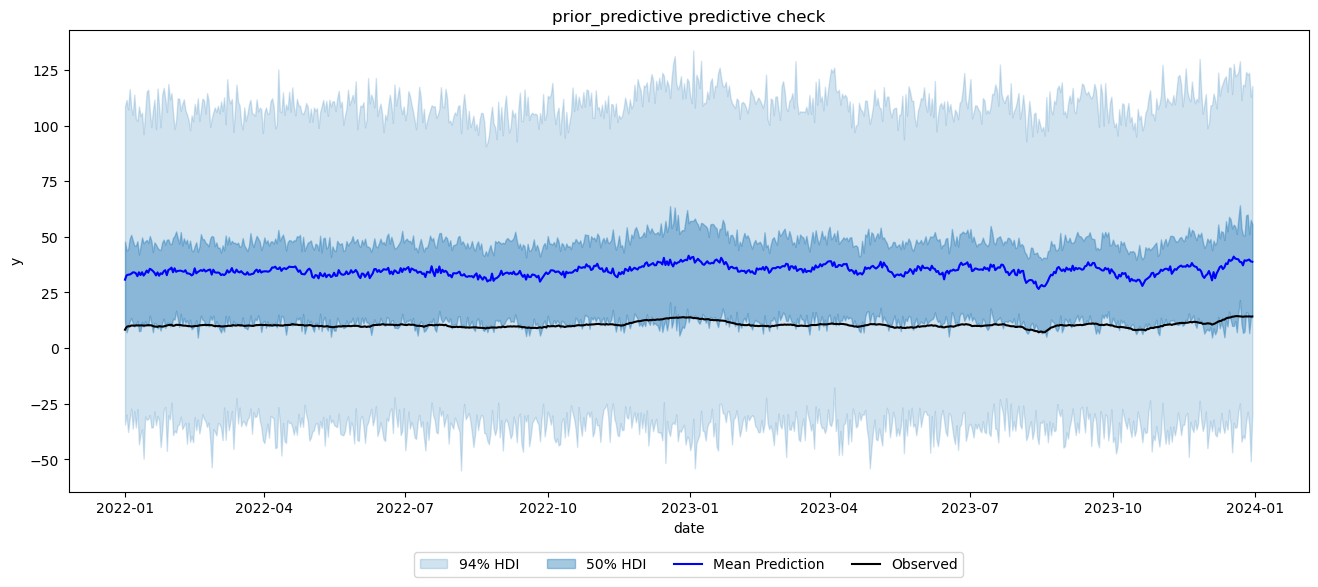

In [51]:
fig, ax = plt.subplots(figsize=(16, 6))
model_bayesian.plot_prior_predictive(ax=ax, original_scale=True)
ax.legend(loc="lower center", bbox_to_anchor=(0.5, -0.2), ncol=4);

### Fit

In [52]:
_ = model_bayesian.fit(X_train_scaled, y_train_scaled, **sampler_config)

C:\Users\kbope\anaconda3\envs\mmm\Lib\site-packages\jax\_src\numpy\array_methods.py:121: UserWarning: Explicitly requested dtype float64 requested in astype is not available, and will be truncated to dtype float32. To enable more dtypes, set the jax_enable_x64 configuration option or the JAX_ENABLE_X64 shell environment variable. See https://github.com/jax-ml/jax#current-gotchas for more.
  return lax_numpy.astype(self, dtype, copy=copy, device=device)


  0%|          | 0/3500 [00:00<?, ?it/s]

  0%|          | 0/3500 [00:00<?, ?it/s]

  0%|          | 0/3500 [00:00<?, ?it/s]

  0%|          | 0/3500 [00:00<?, ?it/s]

C:\Users\kbope\anaconda3\envs\mmm\Lib\site-packages\jax\_src\numpy\array_methods.py:121: UserWarning: Explicitly requested dtype float64 requested in astype is not available, and will be truncated to dtype float32. To enable more dtypes, set the jax_enable_x64 configuration option or the JAX_ENABLE_X64 shell environment variable. See https://github.com/jax-ml/jax#current-gotchas for more.
  return lax_numpy.astype(self, dtype, copy=copy, device=device)
There were 25 divergences after tuning. Increase `target_accept` or reparameterize.
The rhat statistic is larger than 1.01 for some parameters. This indicates problems during sampling. See https://arxiv.org/abs/1903.08008 for details
The effective sample size per chain is smaller than 100 for some parameters.  A higher number is needed for reliable rhat and ess computation. See https://arxiv.org/abs/1903.08008 for details


### Cleanup

In [53]:
X_train_scaled.drop(date_column, axis=1, inplace=True)

### Save Model

In [54]:
model_bayesian.save('model/model_bayesian.nc')

### Load Model

In [56]:
idata = az.from_netcdf('model/model_bayesian.nc')
print("Attributes of InferenceData:")
print(idata.attrs)

if "fit_data" in idata.groups():
    print("\nValues of 'fit_data' Dataset group:")
    print(idata.fit_data)
else:
    print("\n'fit_data' group not found in the InferenceData object.")

C:\Users\kbope\anaconda3\envs\mmm\Lib\site-packages\arviz\data\inference_data.py:157: UserWarning: fit_data group is not defined in the InferenceData scheme
  warnings.warn(


Attributes of InferenceData:
{'id': 'bcbce0522a5869f2', 'model_type': 'MMM', 'version': '0.0.2', 'sampler_config': '{}', 'model_config': '{"intercept": {"dist": "HalfNormal", "kwargs": {"sigma": 0.5}}, "likelihood": {"dist": "Normal", "kwargs": {"sigma": {"dist": "HalfNormal", "kwargs": {"sigma": 2}}}, "dims": ["date"]}, "gamma_control": {"dist": "Normal", "kwargs": {"mu": 0, "sigma": 1}, "dims": ["control"]}, "gamma_fourier": {"dist": "Laplace", "kwargs": {"mu": 0, "b": 1}, "dims": ["fourier_mode"]}, "intercept_tvp_config": {"m": 200, "L": 729.25, "eta_lam": 1.0, "ls_mu": 100.0, "ls_sigma": 10.0, "cov_func": null}, "media_tvp_config": {"m": 200, "L": 729.25, "eta_lam": 1.0, "ls_mu": 5.0, "ls_sigma": 10.0, "cov_func": null}, "adstock_alpha": {"dist": "Beta", "kwargs": {"alpha": 1, "beta": 3}, "dims": ["channel"]}, "saturation_alpha": {"dist": "Gamma", "kwargs": {"mu": 2, "sigma": 1}, "dims": ["channel"]}, "saturation_lam": {"dist": "HalfNormal", "kwargs": {"sigma": 1}, "dims": ["channe

In [55]:
model_bayesian = MMM.load('model/model_bayesian.nc')

C:\Users\kbope\anaconda3\envs\mmm\Lib\site-packages\dowhy\causal_model.py:583: UserWarning: 6 variables are assumed unobserved because they are not in the dataset. Configure the logging level to `logging.WARNING` or higher for additional details.
  warnings.warn(
C:\Users\kbope\anaconda3\envs\mmm\Lib\site-packages\pymc_marketing\mmm\mmm.py:221: UserWarning: Column competitor_offers in adjustment set not found in data.
                    Not controlling for this may induce bias in treatment effect estimates.
  self.control_columns = self.causal_graphical_model.compute_adjustment_sets(
C:\Users\kbope\anaconda3\envs\mmm\Lib\site-packages\pydantic\_internal\_validate_call.py:111: UserWarning: Yearly seasonality excluded as it's not required for adjustment.
  res = self.__pydantic_validator__.validate_python(pydantic_core.ArgsKwargs(args, kwargs))


DifferentModelError: The file 'model/model_bayesian.nc' does not contain an InferenceData of the same model or configuration as 'MMM'

### Diagnostics

In [ ]:
print(model_bayesian.idata['sample_stats']['diverging'].sum().item())

In [ ]:
var_names=['y_sigma', 'saturation_lam', 'adstock_alpha', 'gamma_control']
if not time_varying_intercept:
    var_names += ['intercept']
if do_causal:
    var_names += ['saturation_alpha']
else:
    var_names += ['saturation_beta', 'gamma_fourier']

print(az.summary(data=model_bayesian.fit_result, var_names=var_names).to_string())

In [ ]:
if 'intercept' not in var_names:
    var_names += ['intercept']
if time_varying_media:
    var_names += ['media_temporal_latent_multiplier_raw_eta', 
                  'media_temporal_latent_multiplier_raw_ls', 
                  'media_temporal_latent_multiplier_raw_hsgp_coefs']
_ = az.plot_trace(data=model_bayesian.fit_result, var_names=var_names, compact=True,
                  backend_kwargs={"figsize": (16, 16), 'layout': 'constrained'})
plt.gcf().suptitle("Model Trace", fontsize=16);

In [ ]:
# Sample from posterior predictive distribution
X_train_scaled[date_column] = pd.to_datetime(X_train_scaled.index)
model_bayesian.sample_posterior_predictive(X_train_scaled, original_scale=True, extend_idata=True, combined=True)
X_train_scaled.drop(date_column, axis=1, inplace=True)

In [ ]:
r2 = az.r2_score(y_true=y_train_scaled.values,
                 y_pred=model_bayesian.idata.posterior_predictive.stack(sample=('chain', 'draw'))['y'].values.T *\
                 model_bayesian.target_transformer['scaler'].scale_.item()).iloc[0]
print("Mean of training R2:", r2)

In [ ]:
fig, ax = plt.subplots(figsize=(16, 6))
model_bayesian.plot_posterior_predictive(ax=ax, original_scale=True, 
                                         add_mean=True, add_gradient=False)
plt.text(0.05, 0.95, f'R2: {r2:.2f}', transform=plt.gca().transAxes,
         fontsize=12, verticalalignment='top')
ax.legend(loc="lower center", bbox_to_anchor=(0.5, -0.2), ncol=4);

In [ ]:
fig, ax = plt.subplots(figsize=(16, 6))
model_bayesian.plot_errors(ax=ax, original_scale=True);
ax.legend(loc="lower center", bbox_to_anchor=(0.5, -0.2), ncol=4);

In [ ]:
errors = model_bayesian.get_errors(original_scale=True)

fig, ax = plt.subplots(figsize=(16, 6))
az.plot_dist(errors, quantiles=[0.25, 0.5, 0.75], ax=ax)
ax.axvline(x=0, color="black", linestyle='--', label='zero')
ax.legend()
ax.set(title="Errors Posterior Distribution");

### Contributions

In [ ]:
figsize = plt.rcParams['figure.figsize']
plt.rcParams['figure.figsize'] = [16, 6]

In [ ]:
model_bayesian.plot_components_contributions(original_scale=True);

In [ ]:
groups = {'Base': ['intercept', 'yearly_seasonality'] + control_columns}
for col in channel_columns:
    groups[f'Channel {col}'] = [col]

fig = model_bayesian.plot_grouped_contribution_breakdown_over_time(stack_groups=groups, original_scale=True)
fig.suptitle("Contribution Breakdown over Time")

In [ ]:
model_bayesian.plot_waterfall_components_decomposition(original_scale=True);

In [ ]:
plt.rcParams['figure.figsize'] = figsize

### Media Deep Dive

In [ ]:
mean_contributions_over_time_df = model_bayesian.compute_mean_contributions_over_time(original_scale=True)
mean_contributions_over_time_df.head()

In [ ]:
channels_contribution_original_scale = model_bayesian.compute_channel_contribution_original_scale()
channels_contribution_original_scale_hdi = az.hdi(ary=channels_contribution_original_scale)

fig, ax = plt.subplots(nrows=len(channel_columns), figsize=(16, 6), ncols=1, sharex=True, sharey=False, layout='constrained')

for i, x in enumerate(channel_columns):
    # HDI estimated contribution in the original scale
    ax[i].fill_between(
        x=X_train_scaled.index,
        y1=channels_contribution_original_scale_hdi.sel(channel=x)["x"][:, 0],
        y2=channels_contribution_original_scale_hdi.sel(channel=x)["x"][:, 1],
        label=rf"{x} $94\%$ HDI contribution",
        alpha=0.4)
    
    # Mean estimated contribution in the original scale
    sns.lineplot(
        x=X_train_scaled.index,
        y=mean_contributions_over_time_df[x].to_numpy(),
        label=f"{x} posterior mean contribution",
        ax=ax[i])
    ax[i].legend(loc="lower center", bbox_to_anchor=(0.5, -0.2), ncol=2)
    ax[i].set(title=f"Channel {x} Contribution over Time", xlabel=None, xticklabels=[])

In [ ]:
model_bayesian.plot_channel_parameter(param_name='adstock_alpha', figsize=(16, 6));

In [ ]:
model_bayesian.plot_channel_parameter(param_name='saturation_lam', figsize=(16, 6));

In [ ]:
if do_causal:
    model_bayesian.plot_channel_parameter(param_name='saturation_alpha', figsize=(16, 6));
else:
    model_bayesian.plot_channel_parameter(param_name='saturation_beta', figsize=(16, 6));

In [ ]:
model_bayesian.plot_channel_contribution_share_hdi(figsize=(16, 6));

In [ ]:
fig = model_bayesian.plot_direct_contribution_curves()
[ax.set(xlabel='Channel Spend') for ax in fig.axes];

In [ ]:
model_bayesian.plot_channel_contributions_grid(start=0, stop=1.5, num=10, 
                                               absolute_xrange=True,
                                               figsize=(16, 6));

### ROAS

In [ ]:
channel_contribution_original_scale = model_bayesian.compute_channel_contribution_original_scale()
spend_sum = X_train_scaled[channel_columns].sum().to_numpy()
roas_samples = (channel_contribution_original_scale.sum(dim='date') / spend_sum[np.newaxis, np.newaxis, :])

fig, axes = plt.subplots(nrows=len(channel_columns), 
                         ncols=1, figsize=(16, 12), sharex=False, sharey=False, layout='constrained')
az.plot_posterior(roas_samples, ax=axes)
for i, x in enumerate(channel_columns):
    axes[i].set(title=f'Channel {x}')
fig.suptitle("ROAS Posterior Distributions", fontsize=16);

### Validate

In [ ]:
X_test_scaled, _ = get_scaled_data(do_scaling, scaler_X, scaler_y, X_test, None, model_bayesian.control_columns)
X_test_scaled.head()

In [ ]:
X_test_scaled[model_bayesian.date_column] = pd.to_datetime(X_test_scaled.index)
result_samples = model_bayesian.sample_posterior_predictive(X_pred=X_test_scaled,
                                                            original_scale=True,
                                                            include_last_observations=True,
                                                            extend_idata=False)
X_test_scaled.drop(model_bayesian.date_column, axis=1, inplace=True)

In [ ]:
result_scaled = result_samples['y'].to_series().groupby('date').mean()
if do_scaling:
    result = pd.Series(data=scaler_y.inverse_transform(result_scaled.values.reshape(-1, 1)).flatten(), index=X_test.index)
else:
    result = result_scaled
print("MAPE from Bayesian:", _mape(result, y_test))
print(result.head())

In [ ]:
r2 = az.r2_score(y_true=y_test.values,
                 y_pred=result.values).iloc[0]
print("Mean of validation R2:", r2)

In [ ]:
_, ax = plt.subplots(figsize=(16, 6))
ax.plot(X_test.index, y_test, color='black')
y_train.plot(ax=ax, color='black', label='observed')

lower, upper = quantiles = [0.025, 0.975]
conf = result_samples['y'].to_series().groupby('date').quantile(quantiles).unstack()
if do_scaling:
    conf[lower] = pd.Series(data=scaler_y.inverse_transform(conf[lower].values.reshape(-1, 1)).flatten(), index=X_test.index)
    conf[upper] = pd.Series(data=scaler_y.inverse_transform(conf[upper].values.reshape(-1, 1)).flatten(), index=X_test.index)
ax.fill_between(X_test.index, conf[lower], conf[upper],
                alpha=0.25, color='blue', label='95% confidence interval')
result.plot(ax=ax, label='predicted', #marker='o', 
            color='blue', linestyle='--')

ax.set(ylabel='y', title='Predictions')
ax.legend(loc='lower center', ncol=3);

In [ ]:
_, ax = plt.subplots(figsize=(16, 6))
ax.plot(X_test.index, y_test, label='observed', marker='o', color='black')

lower, upper = quantiles = [0.025, 0.975]
conf = result_samples['y'].to_series().groupby('date').quantile(quantiles).unstack()
if do_scaling:
    conf[lower] = pd.Series(data=scaler_y.inverse_transform(conf[lower].values.reshape(-1, 1)).flatten(), index=X_test.index)
    conf[upper] = pd.Series(data=scaler_y.inverse_transform(conf[upper].values.reshape(-1, 1)).flatten(), index=X_test.index)
ax.fill_between(X_test.index, conf[lower], conf[upper],
                alpha=0.25, color='blue', label='95% confidence interval')
result.plot(ax=ax, label='predicted', marker='o', color='blue', linestyle='--')
plt.text(0.05, 0.95, f'R2: {r2:.2f}', transform=plt.gca().transAxes,
         fontsize=12, verticalalignment='top')

ax.set(ylabel='y', title='Zoomed-in Predictions')
ax.legend(loc='lower center', ncol=3);

### Media Spend Contribution Simulations

In [ ]:
spends = [0.25, 0.5, 1, 2]

fig, axes = plt.subplots(nrows=len(spends), ncols=1,
                         figsize=(16, 12), sharex=False, sharey=True, layout='constrained')
for ax, spend in zip(axes, spends, strict=True):
    model_bayesian.plot_new_spend_contributions(spend_amount=spend, progressbar=False, ax=ax)
fig.suptitle("Media Spend (one-time) Contribution Simulations", fontsize=16);

### Lift Test

In [ ]:
stop

In [ ]:
df_delta = df_train[channel_columns+['y']].diff(periods=1)

df_delta['no_change_channel_count'] = (df_delta[channel_columns] == 0).sum(axis=1)
df_delta['channel'] = df_delta.apply(lambda row: df_delta[channel_columns].columns[(row[channel_columns] != 0)].tolist()[0]\
                                     if row['no_change_channel_count'] == len(channel_columns) - 1 else None, axis=1)

rename_cols = {'y': 'delta_y'}
for col in channel_columns:
    rename_cols[col] = 'delta_' + col
df_delta.rename(columns=rename_cols, inplace=True)

df_delta['x'] = df_delta.apply(lambda row: df_train[row['channel']].shift(1)[row.name]\
                               if row['channel'] is not None else None, axis=1)

df_delta['delta_x'] = df_delta.apply(lambda row: df_delta['delta_' + row['channel']][row.name]\
                                     if pd.notna(row['channel']) else None, axis=1)

df_delta.drop('no_change_channel_count', axis=1, inplace=True)

df_delta.head()

In [ ]:
df_lift_test = df_delta.dropna().copy()
df_lift_test.drop(['delta_'+col for col in channel_columns], axis=1, inplace=True)
df_lift_test = df_lift_test[(df_lift_test['delta_x'] * df_lift_test['delta_y']) >= 0]
df_lift_test['sigma'] = df_delta['delta_y'].std()
df_lift_test.reset_index(inplace=True)
df_lift_test.head()

In [ ]:
_ = MMM.load('model/model_bayesian.nc')

date_column = _.date_column
channel_columns = _.channel_columns
fourier_modes = _.yearly_seasonality

model_config = _.model_config
time_varying_intercept = _.time_varying_intercept
time_varying_media = _.time_varying_media
sampler_config = _.sampler_config

causal_config = {}
if _.dag is not None:
    causal_config['dag'] = _.dag
    causal_config['outcome_node'] = _.outcome_node

In [ ]:
model_bayesian_lift = MMM(date_column=date_column, 
                          channel_columns=channel_columns, 
                          control_columns=control_columns,
                          adstock=adstock, 
                          adstock_first=True,
                          saturation=saturation, 
                          yearly_seasonality=fourier_modes,
                          time_varying_intercept=time_varying_intercept, 
                          time_varying_media=time_varying_media, 
                          **causal_config)
model_bayesian_lift.model_config = model_config

In [ ]:
X_train_scaled[date_column] = list(X_train_scaled.index.strftime("%Y-%m-%d"))

model_bayesian_lift.build_model(X_train_scaled, y_train_scaled, **sampler_config)
model_bayesian_lift.add_lift_test_measurements(df_lift_test=df_lift_test)
_ = model_bayesian_lift.fit(X_train_scaled, y_train_scaled, **sampler_config)

X_train_scaled.drop(date_column, axis=1, inplace=True)

In [ ]:
X_train_scaled[date_column] = pd.to_datetime(X_train_scaled.index)
_ = model_bayesian_lift.sample_posterior_predictive(X_train_scaled, original_scale=True, extend_idata=True, combined=True)
X_train_scaled.drop(date_column, axis=1, inplace=True)

In [ ]:
print(model_bayesian_lift.idata['sample_stats']['diverging'].sum().item())